Escribir el siguiente comando en la terminal para instalar las librerías necesarias: 

*pip install -r requirements.txt*

In [1]:
# pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import scipy
from fitter import Fitter

## 1. Selección de una serie temporal económica

Seleccionar una serie económica (stock Price, bitcoin, tasa de cambio etc..), que muestre un comportamiento parecido a una “caminata aleatoria”. Los datos deben estar actualizados hasta el 31/03/2024

In [3]:
# Cargar datos de google finance
df = yf.download('AMZN', start='2020-01-01', end='2024-03-31') 
df.head(5) # Visualizar las primeras 5 filas

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000


In [4]:
df.tail(5) # Visualizar las últimas 5 filas

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-22,177.750000,179.259995,176.750000,178.869995,178.869995,27964100
2024-03-25,178.009995,180.990005,177.240005,179.710007,179.710007,29815500
2024-03-26,180.149994,180.449997,177.949997,178.300003,178.300003,29659000
2024-03-27,179.880005,180.000000,177.309998,179.830002,179.830002,33272600
2024-03-28,180.169998,181.699997,179.259995,180.380005,180.380005,38051600


Los datos están disponibles hasta el 2024-03-28 (yyyy-mm-dd)

In [5]:
df.shape # Dimensiones del dataframe

(1067, 6)

In [6]:
df2 = df[["Adj Close"]] # Seleccionar solo la columna de precios de cierre ajustados
df2.head(5)

,Adj Close
Date,
2020-01-02,94.900497
2020-01-03,93.748497
2020-01-06,95.143997
2020-01-07,95.343002
2020-01-08,94.598503


In [7]:
df2.tail(5) # Visualizar las últimas 5 filas

,Adj Close
Date,
2024-03-22,178.869995
2024-03-25,179.710007
2024-03-26,178.300003
2024-03-27,179.830002
2024-03-28,180.380005


<Axes: title={'center': 'Amazon Adjusted Stock Price'}, xlabel='Date'>

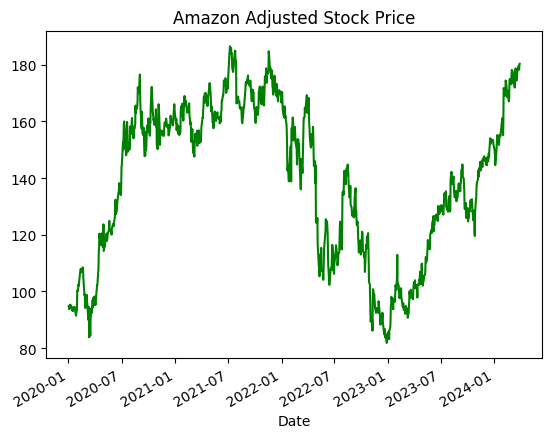

In [8]:
df2["Adj Close"].plot(title = "Amazon Adjusted Stock Price", color = "green")

Hurst exponent (H) is a measure for the long-term memory of a time series, that is, it measures the amount by which that series deviates from a random walk. The values of the Hurst exponent range between 0 and 1, with the following interpretation:

* H < 0.5—a series is mean-reverting. The closer the value is to 0, the stronger the mean-reversion process is. 
* H = 0.5—a series is a geometric random walk. 
* H > 0.5—a series is trending. The closer the value is to 1, the stronger the trend. 

There are a few ways of calculating the Hurst exponent. In this recipe, we will focus on the one based on estimating the rate of the diffusive behavior, which is based on the variance of log prices.

In [9]:
# Define a function calculating the Hurst exponent:
def get_hurst_exponent(ts, max_lag=20):
    """Returns the Hurst Exponent of the time series"""

    lags = range(2, max_lag)

    # standard deviations of the lagged differences
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    hurst_exp = np.polyfit(np.log(lags), np.log(tau), 1)[0]

    return hurst_exp

The calculations of the Hurst exponent can be summarized in two steps:

For each lag in the considered range, we calculate the standard deviation of the differenced series. Calculate the slope of the log plot of lags versus the standard deviations to get the Hurst exponent.

In [10]:
for lag in [20, 100, 250, 500]:
    hurst_exp = get_hurst_exponent(df["Adj Close"].values, lag)
    print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}");

Hurst exponent with 20 lags: 0.4816
Hurst exponent with 100 lags: 0.4725
Hurst exponent with 250 lags: 0.4995
Hurst exponent with 500 lags: 0.4372


Los valores son más cercanos a 0.5, por lo que se considera a la serie como una caminata aleatoria

## 2. Modelación con GBM (Geometric Brownian Motion)
Modelar la serie usando modelos estocásticos

Código inspirado en: https://blog.ms-researchhub.com/2021/11/27/modeling-asset-prices-with-geometric-brownian-motion-in-python/

In [11]:
import pmdarima
from sklearn.metrics import mean_absolute_percentage_error as mape

In [12]:
df2["log_rtn"] = np.log(df2["Adj Close"]/df2["Adj Close"].shift(1))
df2 = df2[["Adj Close", "log_rtn"]].dropna()
df2.head(5)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_25956\487191774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["log_rtn"] = np.log(df2["Adj Close"]/df2["Adj Close"].shift(1))


,Adj Close,log_rtn
Date,,
2020-01-03,93.748497,-0.012213
2020-01-06,95.143997,0.014776
2020-01-07,95.343002,0.002089
2020-01-08,94.598503,-0.007839
2020-01-09,95.052498,0.004788


In [13]:
train, test = pmdarima.model_selection.train_test_split(df2["Adj Close"].dropna(), train_size = 0.8)
training, testing = pmdarima.model_selection.train_test_split(df2["log_rtn"].dropna(), train_size = 0.8)

2024-04-12 08:32:29.910 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED _fit distribution (taking more than 120 seconds)
2024-04-12 08:32:30.107 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted anglit distribution with error=4954.0518)


2024-04-12 08:32:30.421 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=4807.29988)
2024-04-12 08:32:30.652 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted argus distribution with error=3038.607712)
2024-04-12 08:32:30.816 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted alpha distribution with error=335.66932)
2024-04-12 08:32:30.942 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted bradford distribution with error=3873.659912)
2024-04-12 08:32:31.184 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=292.768112)
2024-04-12 08:32:31.232 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=266.390671)
2024-04-12 08:32:31.285 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted betaprime distribution with error=296.66092)
2024-04-12 08:32:31.712 | INFO     | fitter.fitter:_fit_single_distributio

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norminvgauss,98.864390,148.431616,167.421962,inf,0.012738,0.998854
johnsonsu,101.085611,143.029474,162.019820,inf,0.013820,0.996172
hypsecant,101.339564,189.434863,198.930036,inf,0.015598,0.983688
genhyperbolic,101.545512,144.039473,167.777406,inf,0.013758,0.996400
tukeylambda,103.066829,143.216270,157.459030,inf,0.019582,0.892992


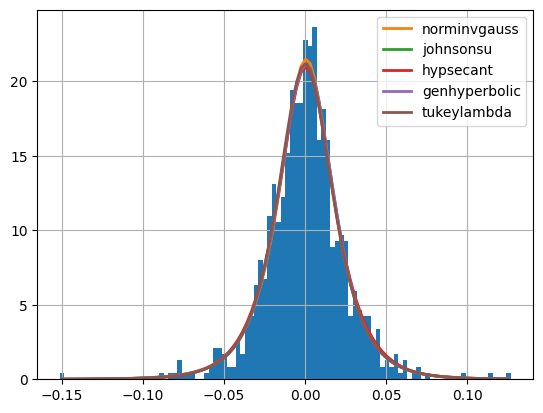

In [14]:
f = Fitter(training, timeout = 120)
f.fit()
f.summary()

In [15]:
# El método get_best se utiliza para seleccionar el mejor modelo basado en un criterio específico. 
# En este caso, el criterio es el "bic", que se refiere al Criterio de Información Bayesiano.
f.get_best(method = "bic")

{'uniform': {'loc': -0.15139791287665294, 'scale': 0.2783468286451102}}

In [16]:
# El método get_best se utiliza para seleccionar el mejor modelo basado en un criterio específico. 
# En este caso, el criterio es el "sumsquare_error", que se refiere a la suma de los errores al cuadrado.
f.get_best(method = "sumsquare_error")

{'norminvgauss': {'a': 0.9753668732438454,
  'b': -0.026601118197388612,
  'loc': 0.0008819343939723866,
  'scale': 0.02405741263947861}}

In [17]:
# El método get_best se utiliza para seleccionar el mejor modelo basado en un criterio específico. 
# En este caso, el criterio es 
f.get_best(method = "aic")

{'uniform': {'loc': -0.15139791287665294, 'scale': 0.2783468286451102}}

Usando los modelos que fueron seleccionados como mejores (según su respectivo criterio), se procedió a realizar una predicción y con ello evaluar al modelo

### Norminvgauss distribution.

Encontrar el mejor modelo probando distintos hiperparámetros.

In [39]:
def GBMsimulatorUniVar_Normgauss(So, mu, sigma, T, N, a = 0.9753668732438454, b = -0.026601118197388612, scale = 0.02405741263947861, loc = 0.0008819343939723866):
    """ This methods uses random numbers to repeatedly sample future results – in our case, we sample 
    random numbers from a Uniform Distribution, then multiply them to our volatility to obtain our diffusion term."""
    dim = np.size(So)
    S = np.zeros([T + 1, int(N)])
    S[0, :] = So
    for t in range(1, int(T) + 1):
        for i in range(0, int(N)):    
            drift = (mu - 0.5 * sigma**2)
            Z = scipy.stats.norminvgauss.rvs(a=a, b=b, scale = scale, loc = loc, random_state = 0)
            # Z = scipy.stats.laplace.rvs()
            diffusion = sigma*Z
            S[t][i] = S[t - 1][i]*np.exp(drift + diffusion)
    return S[1:]


In [40]:
# Create a pandas dataframe that saves the results of the model.
results_NIG = pd.DataFrame(columns = ["MAPE", "Scale", "Loc"]) 
results_NIG

,MAPE,Scale,Loc


In [41]:
# Iterating over the scale and loc parameters
# {{'norminvgauss': {'a': 0.9753668732438454, 'b': -0.026601118197388612, 'loc': 0.0008819343939723866, 'scale': 0.02405741263947861}}
# a > 0, |b| <= a
for scale in [1, 0.02405741263947861]:
    for loc in [0, 0.0008819343939723866]:
        prices = GBMsimulatorUniVar_Normgauss(So = df2["Adj Close"].iloc[len(training)], mu = training.mean(), sigma = training.std(),  
                                         T = len(test), N = 1000, loc = loc, scale = scale)
        newpreds = pd.DataFrame(prices).mean(axis = 1)
        varMAPE = mape(newpreds, test.dropna())
        new_row_values = {"MAPE": varMAPE, "Scale": scale, "Loc": loc}
        results_NIG.loc[len(results_NIG)] = new_row_values

In [42]:
results_NIG.head(10)

,MAPE,Scale,Loc
0,0.205882,1.000000,0.000000
1,0.207473,1.000000,0.000882
2,0.248215,0.024057,0.000000
3,0.245144,0.024057,0.000882


El modelo con valores fijos $a = 0.9753668732438454$ y $b = -0.026601118197388612$ que tiene menor MAPE es aquel con los valores $scale = 1$ y $loc = 0$. En consecuencia, se procederá a usar estos parámetros para visualizar el rendimiento del modelo.

In [43]:
prices = GBMsimulatorUniVar_Normgauss(So = df2["Adj Close"].iloc[len(training)], mu = training.mean(), sigma = training.std(),
                                      T = len(test), N = 1000, loc = 0, scale = 1)
newpreds = pd.DataFrame(prices).mean(axis = 1)
mape(newpreds, test.dropna())

0.24514405133075046

Taking the mean average prediction error (MAPE), we find around 20.58% forecasting error.

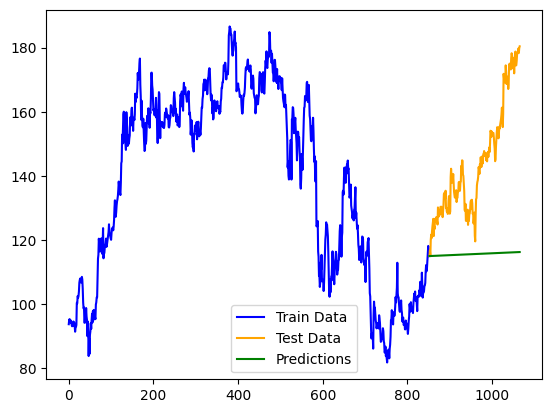

In [44]:
axis = np.arange(len(train) + len(test))
plt.plot(axis[:len(train)], train, c = "blue", label = "Train Data")
plt.plot(axis[len(train):], test, c = "orange", label = "Test Data")
plt.plot(axis[len(train):], np.array(newpreds), c = "green", label = "Predictions")
plt.legend()
plt.show();

### Uniform distribution.

Encontrar el mejor modelo probando distintos hiperparámetros.

In [45]:
def GBMsimulatorUniVar2_UNF(So, mu, sigma, T, N, loc = 0, scale = 1):
    """ This methods uses random numbers to repeatedly sample future results – in our case, we sample 
    random numbers from a Uniform Distribution, then multiply them to our volatility to obtain our diffusion term."""
    dim = np.size(So)
    S = np.zeros([T + 1, int(N)])
    S[0, :] = So
    for t in range(1, int(T) + 1):
        for i in range(0, int(N)):    
            drift = (mu - 0.5 * sigma**2)
            Z = scipy.stats.uniform.rvs(scale =  scale, loc = loc, random_state = 0)
            diffusion = sigma*Z
            S[t][i] = S[t - 1][i]*np.exp(drift + diffusion)
    return S[1:]

In [46]:
# Create a pandas dataframe that saves the results of the model.
results_UNIF = pd.DataFrame(columns = ["MAPE", "Scale", "Loc"]) 
results_UNIF

,MAPE,Scale,Loc


In [47]:
# Iterating over the scale and loc parameters
# {'uniform': {'loc': -0.15139791287665294, 'scale': 0.2783468286451102}}
for scale in [1, 0.2783468286451102]:
    for loc in [0, -0.15139791287665294]:
        prices = GBMsimulatorUniVar2_UNF(So = df2["Adj Close"].iloc[len(training)], mu = training.mean(), sigma = training.std(),  
                                             T = len(test), N = 1000, loc = loc, scale = scale)
        newpreds = pd.DataFrame(prices).mean(axis = 1)
        varMAPE = mape(newpreds, test.dropna())
        new_row_values = {"MAPE": varMAPE,
                          "Scale": scale, "Loc": loc}
        results_UNIF.loc[len(results_UNIF)] = new_row_values

In [48]:
results_UNIF.head(10)

,MAPE,Scale,Loc
0,0.619272,1.000000,0.000000
1,0.502912,1.000000,-0.151398
2,0.163199,0.278347,0.000000
3,0.258277,0.278347,-0.151398


El modelo que tiene menor MAPE es aquel con los valores scale = 0.2783 y loc = 0. En consecuencia, se procederá a usar estos parámetros para visualizar el rendimiento del modelo.

In [49]:
prices = GBMsimulatorUniVar2_UNF(So = df2["Adj Close"].iloc[len(training)], mu = training.mean(), sigma = training.std(), T = len(test), N = 1000,
                                 loc = 0, scale = 0.278347)
newpreds = pd.DataFrame(prices).mean(axis = 1)
mape(newpreds, test.dropna())

0.2582768674033841

Taking the mean average prediction error (MAPE), we find around 16.31% forecasting error.

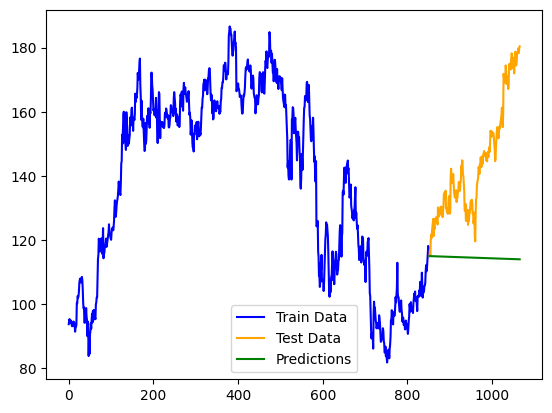

In [50]:
# Agregar una legenda a cada gráfico.
axis = np.arange(len(train) + len(test))
plt.plot(axis[:len(train)], train, c = "blue", label = "Train Data")
plt.plot(axis[len(train):], test, c = "orange", label = "Test Data")
plt.plot(axis[len(train):], np.array(newpreds), c = "green", label = "Predictions")
plt.legend()
plt.show();

## 3. Mejora del modelo

In [ ]:
import jumpdiff as jd

El modelo se puede mejorar usando un modelo más complejo, usando “poisson jumps” para simular alzas y bajas de la serie. 
Código inspirado en: https://medium.com/@polanitzer/jump-diffusion-process-with-drift-in-python-simulate-the-future-distribution-of-foreign-exchange-3d448e6f1d95

Primero se deben obtener los valores correspondientes de los siguientes parámetros:
* S0 : The variable’s today value (a.k.a starting value)
* T : The forecast horizon (years)
* μ : The annualized growth or drift rate
* σ : The annualized volatility
* λ : The jump rate of S
* θ : The jump size of S
* M : The number of Monte Carlo simulations
* N : the number of steps

In [ ]:
# Set the model's parameters.
S0 = 1 # The variable’s today value (a.k.a starting value)
μ = 0.05 # The annualized growth or drift rate
σ = 0.25 # The annualized volatility
λ = 0.05 # The jump rate of S
θ = 1.1 # the jump size of S

# Valores arbitrarios para la simulación
T = 5.0 # The forecast horizon (years)
M = 50000 # The number of Monte Carlo simulations
N = 100 # the number of steps

In [ ]:
X = df2
edges, moments = jd.moments(timeseries = X)